In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)
from keras.callbacks import EarlyStopping

In [2]:
#data = pd.read_csv("simon2018.csv")
data = pd.read_csv(r'timeseries_salesdata.csv',delimiter=",")
data.set_index("Date", inplace =True)

In [3]:
validate = data['Sales'].tail(96)
validate = validate.values
test = pd.DataFrame(data['Sales'].tail(93))

In [4]:
train = data["Sales"].iloc[:-96]
uni_data= train

In [5]:
uni_data = uni_data.values
len(uni_data)

900

In [6]:
# univariate cnn lstm 
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D



In [7]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
# define input sequence
raw_seq = uni_data
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 1
n_steps =3
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

In [8]:
def split_sequence2(sequence2, n_steps2):
    X2, y2 = list(), list()
    for i in range(len(sequence2)):
        # find the end of this pattern
        end_ix2 = i + n_steps2
        # check if we are beyond the sequence
        if end_ix2 > len(sequence2)-1:
            break
        # gather input and output parts of the pattern
        seq_x2, seq_y2 = sequence2[i:end_ix2], sequence2[end_ix2]
        X2.append(seq_x2)
        y2.append(seq_y2)
    return array(X2), array(y2)
# define input sequence
raw_seq = validate
# choose a number of time steps
n_steps2 = 3
# split into samples
X2, y2 = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features2 = 1
n_seq2 = 1
n_steps2 =3
X2 = X2.reshape((X2.shape[0], n_seq2, n_steps2, n_features2))

In [9]:
print(X.shape)
print(y.shape)
print(X2.shape)
print(y2.shape)

(897, 1, 3, 1)
(897,)
(93, 1, 3, 1)
(93,)


In [10]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 3, 64)       128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                23000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 23,179
Trainable params: 23,179
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X, y, epochs=100, batch_size=30, verbose=1, validation_data=(X2,y2),callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)


Epoch 1/100
30/30 [==============================] - 110s 243ms/step - loss: 14867597.9355 - val_loss: 57323608.0000
Epoch 2/100
30/30 [==============================] - 1s 20ms/step - loss: 10369956.6774 - val_loss: 38962464.0000
Epoch 3/100
30/30 [==============================] - 0s 15ms/step - loss: 5809550.7097 - val_loss: 29059864.0000
Epoch 4/100
30/30 [==============================] - 0s 12ms/step - loss: 4313765.0565 - val_loss: 30390250.0000
Epoch 5/100
30/30 [==============================] - 1s 19ms/step - loss: 4406357.7581 - val_loss: 29850872.0000
Epoch 6/100
30/30 [==============================] - 0s 13ms/step - loss: 4365793.6210 - val_loss: 29946878.0000
Epoch 7/100
30/30 [==============================] - 0s 9ms/step - loss: 4374775.6210 - val_loss: 29949738.0000
Epoch 8/100
30/30 [==============================] - 0s 13ms/step - loss: 4375130.5887 - val_loss: 29957726.0000
Epoch 9/100
30/30 [==============================] - 0s 6ms/step - loss: 4376238.3306 - val_

In [13]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('CNN-LSTM model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

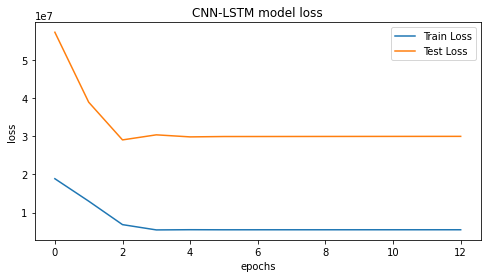

In [14]:
train_score = model.evaluate(X, y, verbose=0)
#print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
#% (np.sqrt(train_score[1]), train_score[2]))
#test_score = model.evaluate(X_test, test_set, verbose=0)
#print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
#% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

In [16]:
pred = model.predict(X2)
len(pred)
forecnn_lstm= pd.DataFrame(pred)
forecnn_lstm.to_csv(r"C:\Users\cash\Desktop\tafa\Forecasting and Predicriom Notebooks&Datasets RJ\exported_CNN-LSTMforecasts_dataframe.csv",index = False,header=True)

In [17]:
actual_fore=test.rename(columns={"Sales":"Actual Sales"})
actual_fore["CNN_LSTM"]=forecnn_lstm.values
cnn_lstm=actual_fore
cnn_lstm

,Actual Sales,CNN_LSTM
Date,,
30-Sep-20,6561.50,6411.743164
1-Oct-20,4599.50,4513.779785
2-Oct-20,4983.00,4999.888672
3-Oct-20,16826.00,4999.888672
4-Oct-20,28484.00,3797.377441
...,...,...
27-Dec-20,3116.25,2884.467285
28-Dec-20,7736.05,2196.976074
29-Dec-20,6981.61,2375.276611


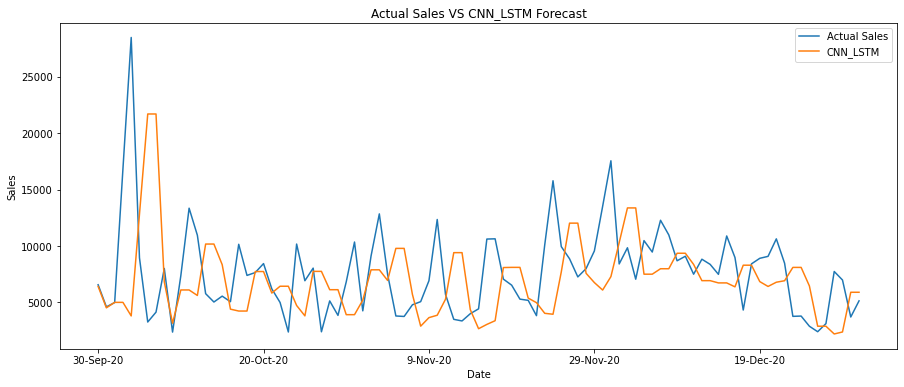

In [18]:
from matplotlib import pyplot
cnn_lstm['Actual Sales'].plot(figsize=(15,6),label="Actual Sales")
cnn_lstm['CNN_LSTM'].plot(figsize=(15,6), label = "CNN_LSTM")
pyplot.xlabel("Date")
pyplot.ylabel("Sales")
pyplot.title("Actual Sales VS CNN_LSTM Forecast")
pyplot.legend()
pyplot.savefig("series plot.png")
pyplot.show()

In [19]:
y_true1 = cnn_lstm["Actual Sales"].dropna()
y_pred1 = cnn_lstm["CNN_LSTM"].dropna()

In [20]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
print(timeseries_evaluation_metrics_func(y_true1, y_pred1))

Evaluation metric results:-
MSE is : 29991120.31381193
MAE is : 3705.5690020161283
RMSE is : 5476.4149143223185
MAPE is : 56.78400668679791
R2 is : -0.9684064962764973

None
